In [1]:
using DataFrames, CSV, GraphPlot, Impute, Plots, Colors, Statistics, Random, Distributions, JLD

dir = "../Mariana-Paquete/Mariana-Basefunc/"

include(dir*"funciones_de_red.jl")
include(dir*"objetos.jl")
include(dir*"dinamica_conductores.jl")
include(dir*"animaciones.jl")

plot_digraph (generic function with 1 method)

In [2]:
# Parametros
tamano_red = 5;
doble_sentido = false;
center_h_dist = 0.5;
sd_h_dist = 0;
h_distribution = Normal(center_h_dist, sd_h_dist);
n_cars = 600;
ti = 0.0;
tf = 150.0;
max_n_dias = 10;
path_jld = "test.jld";
diag_start = [7.,160.];
pendiente = -pi/5;

In [17]:
red_cuadrada = create_square_network(tamano_red, both_ways=doble_sentido)
#red_cuadrada = make_div_del_norte(tamano_red, diag_start, pendiente, both_ways=doble_sentido);
SqNet= red_cuadrada.digraph;
m = nv(SqNet);
posarr = red_cuadrada.position_array;
city_mt = red_cuadrada.city_matrix;

In [18]:
saturation = city_mt[:,:,3]./city_mt[:,:,2];

In [19]:
maximum(filter(!isnan,saturation))

0.0

In [20]:
fig, colors = plot_digraph(SqNet, posarr, attribute_matrix=saturation,
                            separated_edges=true, min_value=0.0, max_value=1.0, c1=colorant"green", c2=colorant"red");

In [21]:
colors

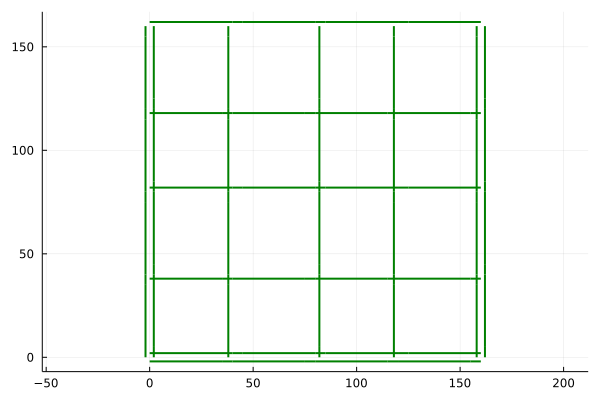

In [22]:
fig

In [23]:
# Generacion de los autos
autos = generate_autos(m,tamano_red,red_cuadrada,n_cars,ti,tf,h_distribution);
tiempos_de_salida_snapshot = [auto.ts for auto in autos];

In [24]:
times, vels, matrix_density, autos_atorados = simulacion!(0., red_cuadrada, autos);

In [25]:
saturation = matrix_density./city_mt[:,:,2];

In [26]:
fig, colors = plot_digraph(SqNet, posarr, attribute_matrix=saturation,
                        separated_edges=true, min_value=0, max_value=1.0, c1=colorant"green", c2=colorant"red");

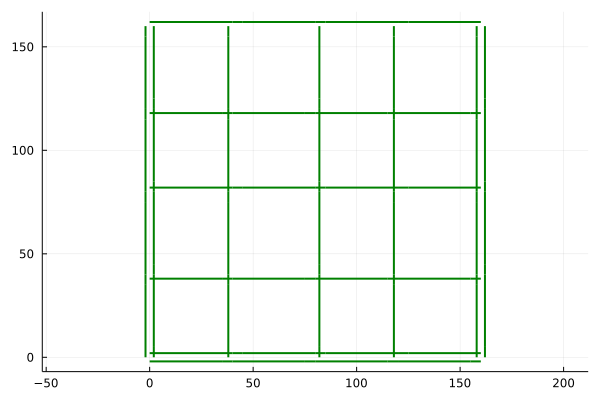

In [27]:
fig

In [28]:
valid_capacities = []
for e in collect(edges(SqNet))
    u = src(e)
    v = dst(e)
    push!(valid_capacities,city_mt[u,v,2])
end

minimum(valid_capacities)

1.0

In [29]:
autos_atorados

6696-element Array{Any,1}:
 [1.0, 0.0]
 [2.0, 0.0]
 [2.0, 0.0]
 [3.0, 0.0]
 [4.0, 0.0]
 [5.0, 0.0]
 [5.0, 0.0]
 [5.0, 0.0]
 [6.0, 0.0]
 [6.0, 0.0]
 [7.0, 0.0]
 [8.0, 0.0]
 [8.0, 0.0]
 ⋮
 [6.0, 0.0]
 [6.0, 0.0]
 [5.0, 0.0]
 [5.0, 0.0]
 [4.0, 0.0]
 [4.0, 0.0]
 [3.0, 0.0]
 [3.0, 0.0]
 [2.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 0.0]

In [31]:
restart(autos, red_cuadrada, tiempos_de_salida_snapshot);

In [32]:
# simulacion
day_simulacion = 0;

save(path_jld, "t", "test")

while day_simulacion < max_n_dias
    print("día $(day_simulacion) \n")
    times, vels, matrix_density, autos_atorados = simulacion!(0., red_cuadrada, autos);
    vels_summ = vels_summary(autos)
    travel_times = times_summary(autos)
    indexes = restart(autos, red_cuadrada, tiempos_de_salida_snapshot)
    information_array = [vels_summ, travel_times, indexes, vels, matrix_density, autos_atorados]

    jldopen(path_jld, "r+") do file
        write(file, string("day", day_simulacion), information_array)
    end

    print(mean(vels_summ),"\n")
    global day_simulacion += 1
end

día 0 
10.177259223665493
día 1 
10.26212295481165
día 2 
10.28540942347465
día 3 
10.292618950157548
día 4 
10.29694424348958
día 5 
10.293614686559042
día 6 
10.280821217879025
día 7 
10.271886908296587
día 8 
10.27342734724793
día 9 
10.269727872059034


In [33]:
function get_information_by_car(days_per_repetition, number_of_cars, reads)
    speeds = [reads[string("day",j)][1][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];
    car_speed_average = mean(speeds,dims=1)[:];
    car_speed_mode = [StatsBase.mode(round.(speeds[:,i],digits=2)) for i in 1:number_of_cars];

    # Time info
    times = [reads[string("day",j)][2][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];
    car_time_average = mean(times,dims=1)[:];
    car_time_mode = [StatsBase.mode(round.(times[:,i],digits=2)) for i in 1:number_of_cars];
    return car_speed_average, car_speed_mode, car_time_average, car_time_mode
end

get_information_by_car (generic function with 1 method)

In [34]:
function get_information_by_day(days_per_repetition, number_of_cars, reads)
    speeds = [reads[string("day",j)][1][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];
    day_speed_average = mean(speeds,dims=2);
    day_speed_mode = [StatsBase.mode(round.(speeds[i,:],digits=2)) for i in 1:days_per_repetition+1][:];

    # Time info
    times = [reads[string("day",j)][2][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];
    day_time_average = mean(times,dims=2);
    day_time_mode = [StatsBase.mode(round.(times[i,:],digits=2)) for i in 1:days_per_repetition+1][:];

    # Get daily indexes and daily means
    daily_indexes = [reads[string("day",i)][3] for i in 0:days_per_repetition];
    daily_mean_indexes = [length(daily_indexes[i])>0 ? mean(daily_indexes[i]) : NaN for i in 1:days_per_repetition+1];
    daily_count_indexes = [length(daily_indexes[i]) for i in 1:days_per_repetition+1];

    return day_speed_average, day_speed_mode, day_time_average, day_time_mode, daily_mean_indexes, daily_count_indexes
end

get_information_by_day (generic function with 1 method)

In [35]:
function red_daily_information(days_per_repetition, number_of_cars, reads)

    # Get daily red speeds and means
    daily_red_vels = [reads[string("day",i)][4] for i in 0:days_per_repetition];
    daily_mean_red_vels = [mean(daily_red_vels[i]) for i in 1:days_per_repetition+1];
    daily_count_red_vels = [length(daily_red_vels[i]) for i in 1:days_per_repetition+1];

    daily_red_final_saturation = [reads[string("day",i)][5] for i in 0:days_per_repetition];

    return daily_mean_red_vels, daily_count_red_vels, daily_red_final_saturation
end

red_daily_information (generic function with 1 method)

In [36]:
function summary_df(days_per_repetition, number_of_cars, reads)
    # Speed info
    speeds = [reads[string("day",j)][1][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];
    
    # Time info
    times = [reads[string("day",j)][2][k]  for j in 0:days_per_repetition, k in 1:number_of_cars];

    # Get daily indexes and daily means
    daily_indexes = [reads[string("day",i)][3] for i in 0:days_per_repetition];
    daily_count_indexes = [length(daily_indexes[i]) for i in 1:days_per_repetition+1];

    df = DataFrame(a = 1:days_per_repetition+1,
               times = [times[i,:] for i in 1:days_per_repetition+1],
               speeds = [times[i,:] for i in 1:days_per_repetition+1],
               ind = daily_indexes,
               ind_count = daily_count_indexes);
    return df
end


summary_df (generic function with 1 method)

# Read the file

In [37]:
reads = load("test.jld");

In [43]:
days_per_repetition = 9
number_of_cars = 600

600

## Get general information

In [52]:
using StatsBase, StatsPlots

In [46]:
day_speed_average, day_speed_mode, day_time_average, day_time_mode, daily_mean_indexes, daily_count_indexes = get_information_by_day(days_per_repetition, number_of_cars, reads);

In [47]:
car_speed_average, car_speed_mode, car_time_average, car_time_mode = get_information_by_car(days_per_repetition, number_of_cars, reads);

In [48]:
daily_mean_red_vels, daily_count_red_vels, daily_red_final_saturation = red_daily_information(days_per_repetition, number_of_cars, reads);

In [49]:
df = summary_df(days_per_repetition, number_of_cars, reads);

### Graficos de tiempo

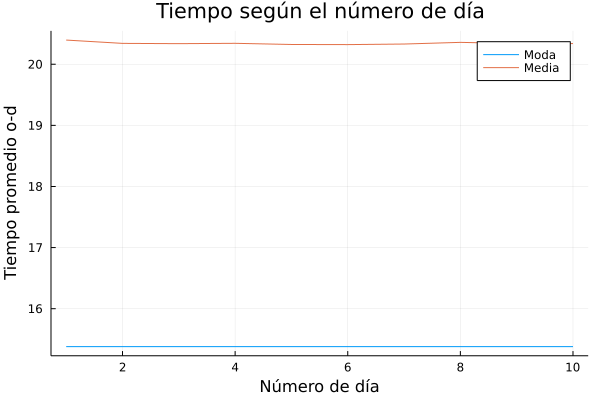

In [65]:
plot([i*1.0 for i in 1:length(day_time_mode)], day_time_mode, label="Moda", xlabel="Número de día", ylabel="Tiempo promedio o-d")
plot!([i*1.0 for i in 1:length(day_time_average)], day_time_average, label="Media", title="Tiempo según el número de día")

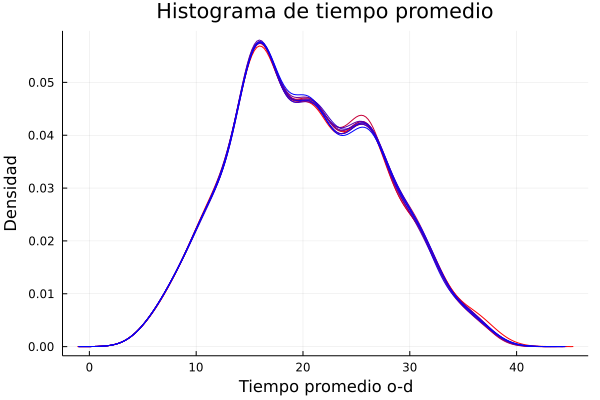

In [66]:
@df df StatsPlots.density(:times, title="Histograma de tiempo promedio", palette=palette([:red, :blue], length(:times)), legend=false, xlabel="Tiempo promedio o-d", ylabel="Densidad")

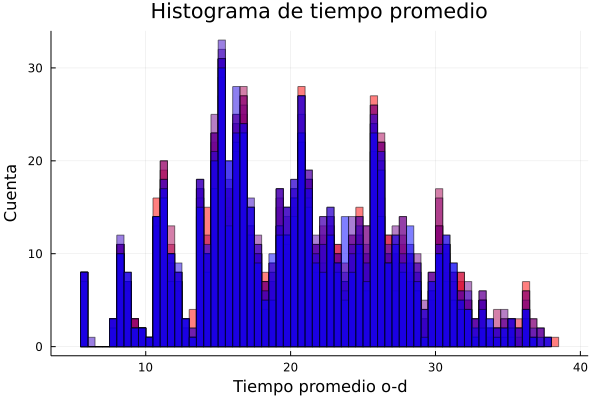

In [67]:
@df df histogram(:times, title="Histograma de tiempo promedio", palette=palette([:red, :blue], length(:times)), legend=false, bins=100, alpha=0.5, xlabel="Tiempo promedio o-d", ylabel="Cuenta")

In [68]:
mean(day_time_average)

20.342658224748188

### Estadísticas de velocidad

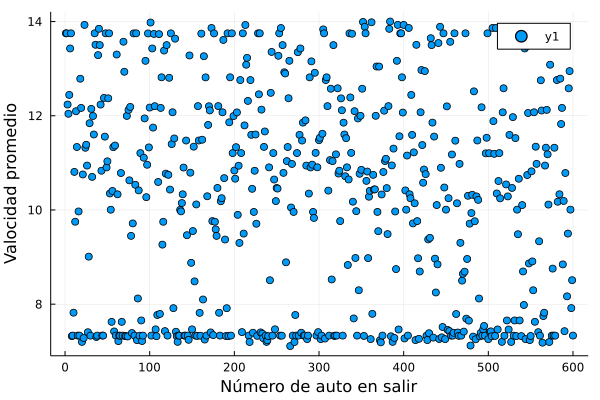

In [69]:
plot(car_speed_average,seriestype = :scatter, xlabel="Número de auto en salir", ylabel="Valocidad promedio")

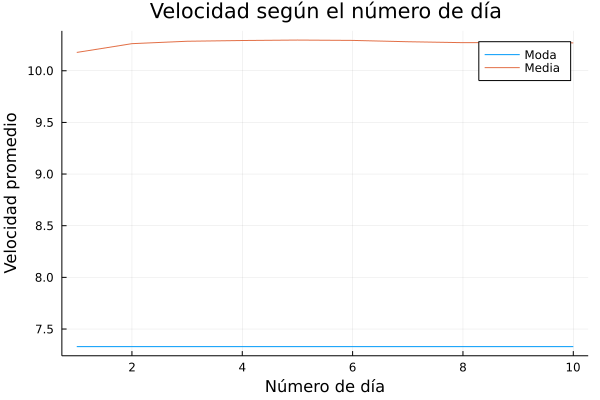

In [70]:
plot([i*1.0 for i in 1:length(day_speed_mode)], day_speed_mode, label="Moda", xlabel="Número de día", ylabel="Velocidad promedio")
plot!([i*1.0 for i in 1:length(day_speed_average)], day_speed_average, label="Media", title="Velocidad según el número de día")

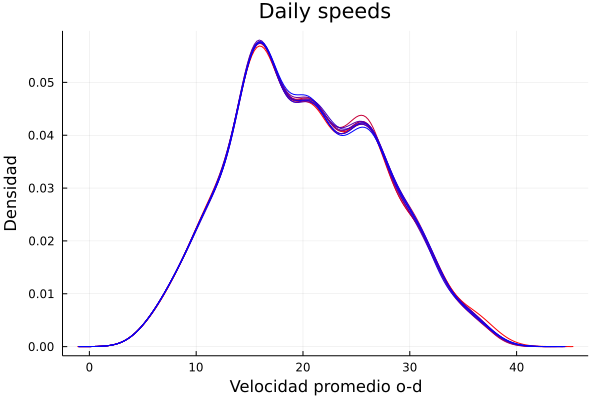

In [71]:
@df df StatsPlots.density(:speeds, title="Daily speeds", palette=palette([:red, :blue], length(:speeds)), legend=false, xlabel="Velocidad promedio o-d", ylabel="Densidad")

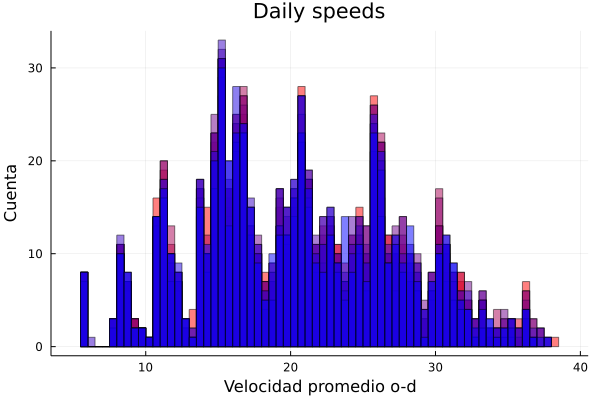

In [72]:
@df df histogram(:speeds, title="Daily speeds", palette=palette([:red, :blue], length(:speeds)), legend=false, bins=100, alpha=0.5, xlabel="Velocidad promedio o-d", ylabel="Cuenta")

In [73]:
mean(day_speed_average)

10.27038328276405

### Estadisticas de indices de autos cambiando

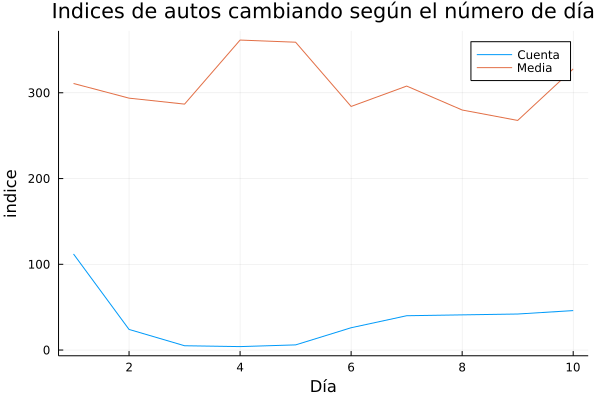

In [64]:
plot([i*1.0 for i in 1:length(daily_count_indexes)], daily_count_indexes, label="Cuenta", xlabel="Día", ylabel="indice")
plot!([i*1.0 for i in 1:length(daily_mean_indexes)], daily_mean_indexes, label="Media", title="Indices de autos cambiando según el número de día")